In [1]:
import numpy as np
from pprint import pprint
import random
import copy
import itertools

In [2]:
# function for generate distance matrix
def distanceMatrix(length):
    grid = []
    for i in range(length):
        grid_sub = []
        for j in range(length):
            grid_sub.append(0)
        grid.append(grid_sub)

    for i in range(0, length - 1):
        for j in range(0, length - 1 - i):
            node = int(random.randint(20, 60))
            grid[i][i + j + 1] = node
            grid[i + j + 1][i] = node
    return grid

# function for generate all possible route for exhaustive search
def generateAllRoutes(length):
    nodes = [ x for x in range(2, length + 1) ]

    routes = list(map(list, itertools.permutations(nodes)))

    for x in routes:
        x.insert(0, 1)
        x.insert(length + 1, 1)
    return routes

# function for calculate exhaustive search
def exhautiveSearch(routes, matrix):
    travelCosts = []

    for route in routes:
        travelCost = 0
        for i in range(1, len(route)):
            route1 = route[i-1]
            route2 = route[i]
            travelCost += matrix[route1 - 1][route2 - 1]
        travelCosts.append(travelCost)

    minCost = min(travelCosts)
    shortest = routes[travelCosts.index(minCost)]
    return shortest, minCost

In [3]:
# function for calculate fitness
def fitness(route, matrix):
    fit = 0
    for i in range(1, len(route)):
        route1 = route[i-1]
        route2 = route[i]
        fit += matrix[route1 - 1][route2 - 1]
    return list([route, fit])

# function for generate random swap value
# source: https://stackoverflow.com/questions/22229796/choose-at-random-from-combinations
def random_combination(iterable, r):
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), r))
    return list([pool[i] for i in indices])

# function for generate swap list
def swapList(route, matrix, move):
    swap_list = []
    swap_set = set()
    count = 0
    while count < move:
        temp = random_combination(range(2, 9), 2)
        if str(temp) not in swap_set:
            swap_list.append(temp)
            swap_set.add(str(temp))
            count += 1

    swap_obj = []
    for swap in swap_list:
        r = copy.copy(route)
        for i, node in enumerate(r):
            if node == swap[0]:
                r[i] = swap[1]

            if node == swap[1]:
                r[i] = swap[0]
        fit = fitness(r, matrix)
        fit.insert(0, swap)
        swap_obj.append(fit)
    return swap_obj

## EXHAUSTIVE SEARCH

In [4]:
total_node = 9

matrix = distanceMatrix(total_node)

routes = generateAllRoutes(total_node)
shortest, cost = exhautiveSearch(routes, matrix)

print('Route: %s' % (shortest))
print('Cost : %d' % (cost))

Route: [1, 2, 3, 7, 5, 4, 8, 6, 9, 1]
Cost : 253


## TABU SEARCH 

Route: [1, 3, 7, 5, 4, 2, 9, 6, 8, 1]
Cost : 263


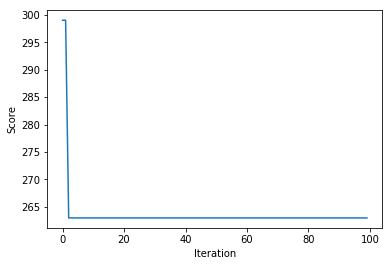

In [6]:
iteration   = 100
move        = 10
aspiration  = 5
tenure      = 3
total_node  = 9

# generate initial solution
route = routes[random.randint(0, len(routes))]
solution = fitness(route, matrix)

# generate empty tabu list
tabulist = []
for i in range(total_node):
    temp = []
    for j in range(total_node):
        temp.append(0)
    tabulist.append(temp)

# start iteration
objs = []
obj_route = []
obj_value = 0
max_obj = 9999999
for n in range(iteration):
    # reduce tabu tenure by 1 each iteration
    for i in range(0, total_node - 1):
        for j in range(total_node - 1 - i):
            if tabulist[i][i + j + 1] > 0:
                tabulist[i][i + j + 1] -= 1
    
    # generate 5 random swap move
    swap_list = swapList(solution[0], matrix, move)

    # penalty by frequency
    for i, swap in enumerate(swap_list):
        value = tabulist[swap[0][1]][swap[0][0]]
        total = swap_list[i][2] + value
        swap.insert(len(swap)+1, total)
    swap_list.sort(key=lambda x: x[3])
    
    # evaluate move by aspiration criterion
    x = swap_list[0][0][0]
    y = swap_list[0][0][1]

    # if tabulist empty for first swap list
    if tabulist[x][y] == 0:
        tabulist[x][y] = tenure
        tabulist[y][x] += 1
        obj_value = swap_list[0][2]
        obj_route.append([obj_value, swap_list[0][1]])
    # if tabulist not empty for first swap list
    else:
        # if objective value difference more than aspiration criterion
        if swap_list[0][3] - obj_value > aspiration:
            tabulist[x][y] = tenure
            tabulist[y][x] += 1
            obj_value = swap_list[0][2]
            obj_route.append([obj_value, swap_list[0][1]])
        # if objective value difference less than aspiration criterion
        else:
            # check for the next swap list
            for i, swap in enumerate(swap_list):
                if i != 0:
                    if tabulist[swap[0][0]][swap[0][1]] == 0:
                        tabulist[swap[0][0]][swap[0][1]] = tenure
                        tabulist[swap[0][1]][swap[0][0]] += 1
                        obj_value = swap[2]
                        obj_route.append([obj_value, swap[1]])
                        break
                    else:
                         if swap[3] - obj_value > aspiration:
                            tabulist[swap[0][0]][swap[0][1]] = tenure
                            tabulist[swap[0][1]][swap[0][0]] += 1
                            obj_value = swap[2]
                            obj_route.append([obj_value, swap[1]])
                            break
    
    if obj_value < max_obj:
        max_obj = obj_value
    objs.append(max_obj)

obj_route.sort(key=lambda x: x[0])
print('Route: %s' % (obj_route[0][1]))
print('Cost : %d' % (obj_route[0][0]))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(objs)
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.show()